<div class="alert alert-success">
At first, since there are no names for the columns of our data, we will start by creating them :
</div>

In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt 
import pandas as pd
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score,roc_curve,confusion_matrix,precision_score,classification_report,f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.utils import resample
from sklearn.naive_bayes import GaussianNB

In [2]:
names = ['age',
          'class of worker',
          'detailed industry recode',
          'detailed occupation recode',
          'education',
          'wage per hour',
          'enroll in edu inst last wk',
          'marital stat',
          'major industry code',
          'major occupation code',
          'race',
          'hispanic origin',
          'sex',
          'member of a labor union',
          'reason for unemployment',
          'full or part time employment stat',
          'capital gains',
          'capital losses',
          'dividends from stock',
          'tax filer stat',
          'region of previous residence',
          'state of prevous residence',
          'detailed household and family stat',
          'detailed household summary in household',
          'instance weight',
          'migration code-change in msa',
          'migration code-change in reg',
          'migration code-move within region',
          'live in this house 1 year ago',
          'migration prev res in sunbelt',
          'num persons worked for employer',
          'family members under 18',
          'country of birth father',
          'country of birth mother',
          'country of birth self',
          'citizenship',
          'own business or self employed',
          "fill inc questionnaire for veteran's admin",
          'veterans benefits',
          'weeks worked in year',
          'year',
          'income']

dftrain=pd.read_csv('census_income_learn.csv',names=names)
dftest=pd.read_csv('census_income_test.csv',names=names)
grouped_dftrain=dftrain.groupby("income")

# Preprocessing :

<div class="alert alert-success">
<p>One way to visualize our columns in order to see which ones we should keep, which ones will be beneficial for training our model and which ones will not (i.e. will act like a noise in our data): <p></p>
We will group our dataframe by income and draw the 'bars' showing each category for a certain feature.
In blue is drawn the amount of '-50000' in our category and in orange the one for '50000+'.
</div>

<div class="alert alert-success">
Trying to analyse class of worker feature we can notice that the most commun one is 'Not in universe' and we can see that this category comes a lot for other features, we assume that It means that data is not available for some cases where a feature can support many categories or it means that this category is not possible for our element, for example the fourth element has 10 years old , the class of worker has no meaning in this case, Not in universe stands then for 'has no sens'
</div>

In [3]:
dftrain.ix[4]

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


age                                                                               10
class of worker                                                      Not in universe
detailed industry recode                                                           0
detailed occupation recode                                                         0
education                                                                   Children
wage per hour                                                                      0
enroll in edu inst last wk                                           Not in universe
marital stat                                                           Never married
major industry code                                      Not in universe or children
major occupation code                                                Not in universe
race                                                                           White
hispanic origin                                                  

<div class="alert alert-success">
Using this visualisation for each feature and starting with age feature we can notice that most young people earn less than 50000 which is logical 

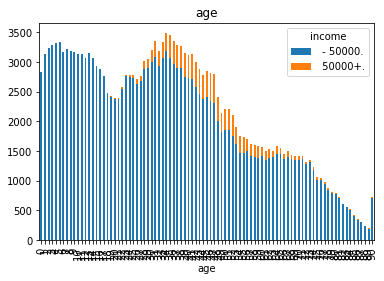

In [14]:
%matplotlib inline
dftrain.groupby('income')['age'].value_counts().unstack(level=0).plot(kind='bar',stacked=True,title='age')

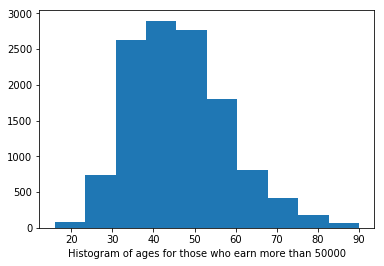

In [15]:
plt.hist(dftrain[dftrain['income']==' 50000+.'].age)
plt.xlabel('Histogram of ages for those who earn more than 50000')
plt.show()

<div class="alert alert-success">
This histogram can show us that the large majority of people who earn more than 50000 are more than 12 years old,we choose to drop from our data elements that have less than 12 years old which would help us create some balance for later since we can notice from the start that elements with more than 50000 elements as income are way more available than those with less than 50000
</div>

In [17]:
dftrain_age=dftrain[dftrain.age>12]

<div class="alert alert-success">
Next, we assume that detailed industry recode,detailed occupation recode won't provide efficient information to our data since even if they are numerical values, they are quantified and spread all over the categories ( i.e. for each detailed recode we may find both kind of incomes > and < 50000,we will drop it later in order to have less noise.
We also assume that other codes such as major industry code,major occupation code,migration code-change in reg,migration code-move within region
</div>

In [18]:
indexesofrecodes=[2,3]

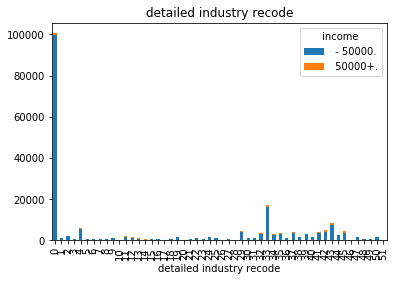

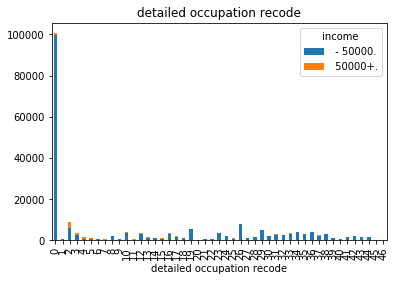

In [19]:
%matplotlib inline
for n in indexesofrecodes:
    dftrain.groupby('income')[names[n]].value_counts().unstack(level=0).plot(kind='bar',stacked=True,title=names[n])

<div class="alert alert-success">
With the same logic for the other features, we decided to drop the features below:
</div>

<div class="alert alert-success">
Now for those indexes_todrop below we have the opposite case of what we had before, here either we find that both kind of incomes are in Not in universe category or/and Not in universe category is way more available than other categories which is the case for 'member of a labor union' which would introduce more noise to our data than it would be beneficial for it
</div>

In [20]:
col=dftrain.columns
indexes_todrop=[6,8,9,13,14,20,25,26,27,29,31,37] 

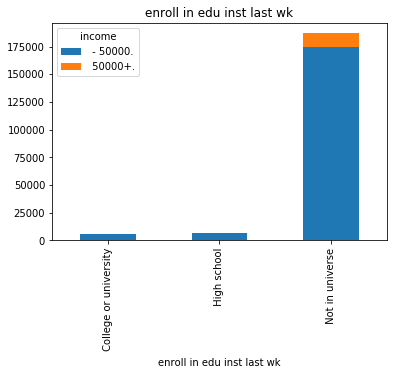

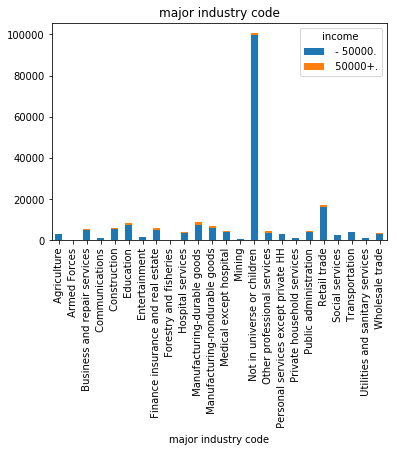

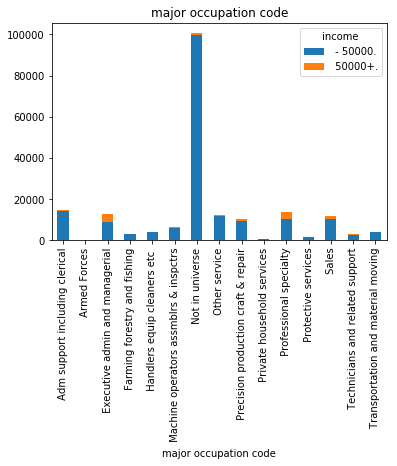

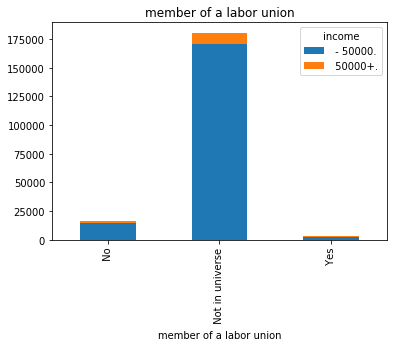

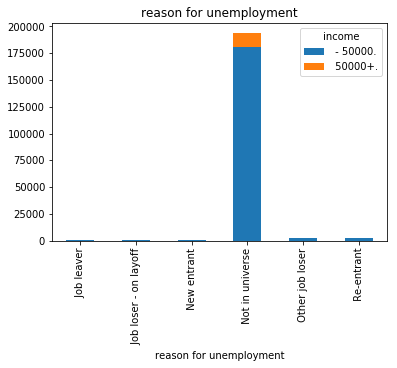

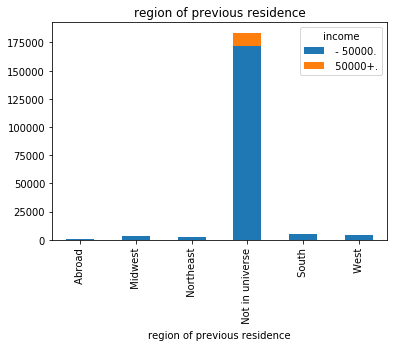

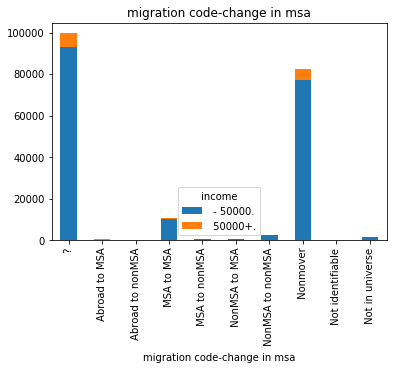

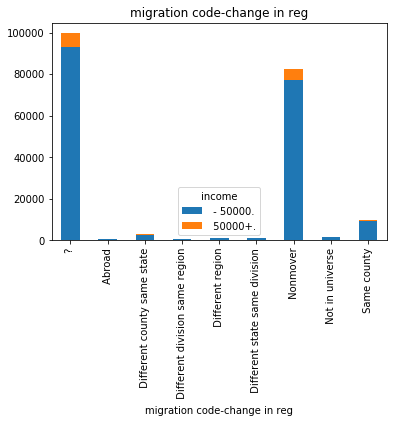

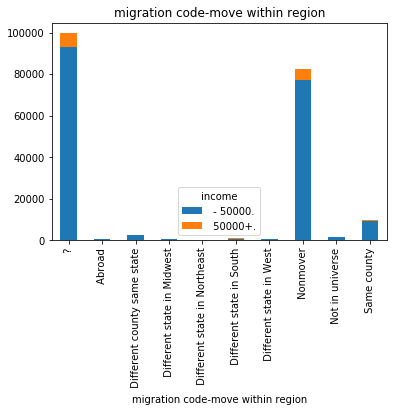

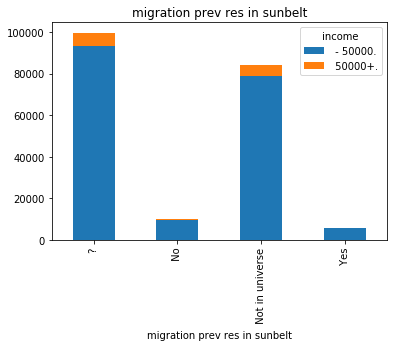

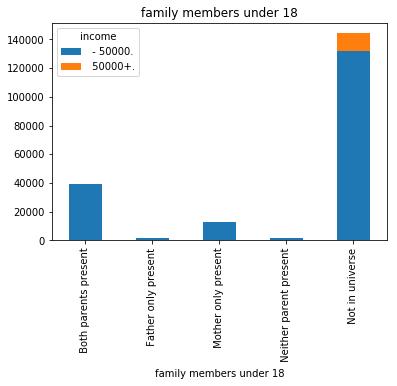

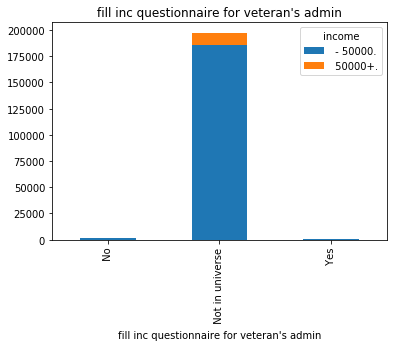

In [21]:
for ind in indexes_todrop:
    dftrain.groupby('income')[col[ind]].value_counts().unstack(level=0).plot(kind='bar',stacked=True,title=col[ind])

<div class="alert alert-success">
Since 'Not in universe' is a category that we have in many features, we assume that It means that data is not available (i.e. NAN). For this case, we can see that the most commun category is 'Not in universe' and in addition to that, the minority class (50 000+) is only available in this category, we can then drop this column since It won't give any new and interesting information/insights for training our model.
</div>

<div class="alert alert-success">
Meanwhile, there are features that would definitely be very beneficial for our model like 'education' which will clearly impact the income or marital stat (a married person may be more productive and then have a better income),while a never married person has more chances to earn less than 50000 as shows this plot
</div>

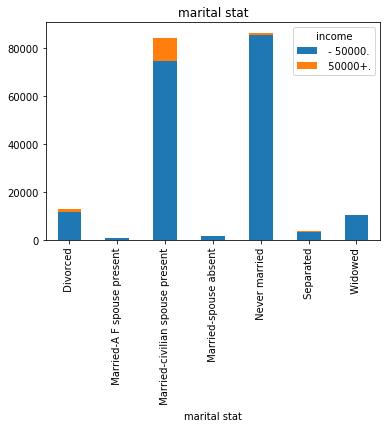

In [22]:
dftrain.groupby('income')[col[7]].value_counts().unstack(level=0).plot(kind='bar',stacked=True,title=col[7])

<div class="alert alert-success">
Education will definitely be good for our model because it is usual to find that people who earn more money are the one with better education even if it is not always the case
</div>

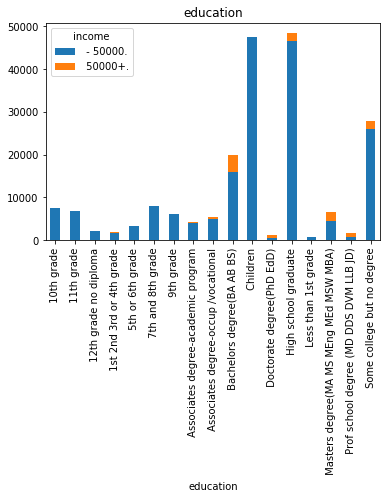

In [23]:
dftrain.groupby('income')[col[4]].value_counts().unstack(level=0).plot(kind='bar',stacked=True,title=col[4])

<div class="alert alert-success">
We chose to keep some features where 'Not in universe' is the most commun with a very high percentage compared to others for the simple reason that we have data for both kind of incomes all over the other categories, which may be interesting for our model. An example is shown below:
</div>

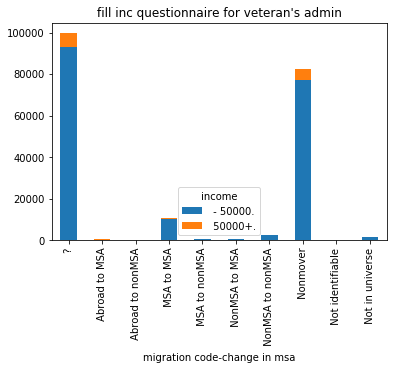

In [24]:

dftrain.groupby('income')['migration code-change in msa'].value_counts().unstack(level=0).plot(kind='bar',stacked=True,title=col[ind])

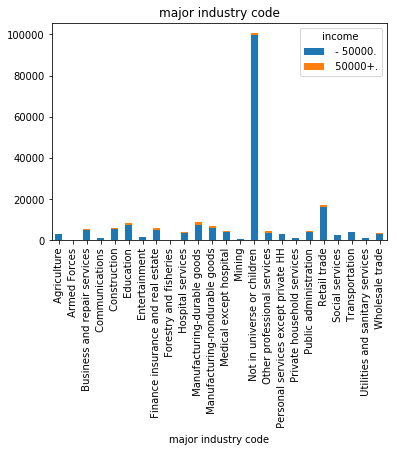

In [25]:
ind=8
dftrain.groupby('income')[col[ind]].value_counts().unstack(level=0).plot(kind='bar',stacked=True,title=col[ind])

In [26]:
dftrain_filtred=dftrain_age.drop(col[indexes_todrop+indexesofrecodes],axis=1)
dftest_filtred=dftest.drop(col[indexes_todrop+indexesofrecodes],axis=1)

In [27]:
categoricals = dftrain_filtred.select_dtypes(include=[np.object]).columns.tolist()
print(categoricals)

['class of worker', 'education', 'marital stat', 'race', 'hispanic origin', 'sex', 'full or part time employment stat', 'tax filer stat', 'state of prevous residence', 'detailed household and family stat', 'detailed household summary in household', 'live in this house 1 year ago', 'country of birth father', 'country of birth mother', 'country of birth self', 'citizenship', 'income']


<div class="alert alert-success">
These are the categorical features in our data that we are planning to convert to numerical values using labelencoding, even if Label encoding could perform very badly when using it with tree models for example since we assume that some categories are better than others when assigning sorted discrete values to them.
</div>

# Onehotencoding for categorical data

In [28]:
from sklearn.preprocessing import OneHotEncoder

In [29]:
big_X=dftrain_filtred.append(dftest_filtred)

In [30]:
def one_hot_encode(df):
    categorical = df.select_dtypes(include=[np.object]).columns.tolist()
    numerical= df.drop(categorical, axis=1, inplace=False, errors='ignore')
    dummies = pd.get_dummies(df[categorical])
    concat_= pd.concat([numerical,dummies],axis=1)
    return concat_

In [31]:
big_y=big_X['income']
big_X_=one_hot_encode(big_X.drop('income',axis=1,inplace=False))

In [32]:
train_X = big_X_[0:dftrain_filtred.shape[0]]
test_X = big_X_[len(train_X):]

In [33]:
le=LabelEncoder()
big_y_=le.fit_transform(big_y)
train_y=big_y_[0:dftrain_filtred.shape[0]]
test_y=big_y_[len(train_y):]

# Machine Learning Models Dealing with Class Imbalance

# Logistic regression

In [34]:
def transform(predictions,threshold):
    for k in range(len(predictions)):
        if predictions[k]>threshold:
            predictions[k]=1
        else:
            predictions[k]=0
            

In [35]:
train_X=np.array(train_X)

<div class="alert alert-success">
We will do a cross validation to choose a threshold for predict_proba, changing this threshold will definitely impact our prediction in a way that will allow us to deal with this class imbalance.
</div>

In [ ]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5)
thresholds=[]
precisions=[]
recalls=[]
f1scores=[]
aucscores=[]
for train_index, test_index in kf.split(train_X):
    for threshold in [0.2,0.3,0.5,0.6,0.7,0.8,0.85,0.9]:
        X_train, X_test = train_X[train_index], train_X[test_index]
        y_train, y_test = train_y[train_index], train_y[test_index]
        clf = LogisticRegression(class_weight='balanced')
        clf.fit(X_train,y_train)
        predictions=[x[1] for x in clf.predict_proba(X_test)]
        transform(predictions,threshold)
        thresholds+=[threshold]
        precisions+=[precision_score(y_test,predictions)]
        recalls+=[recall_score(y_test,predictions)]
        f1scores+=[f1_score(y_test,predictions)]
        aucscores+=[roc_auc_score(y_test,predictions)]

Running this code we find that the best value is 0.8 for our threshold from the values we have chosen manually

In [36]:
threshold=0.8
clf = LogisticRegression(class_weight='balanced')
clf.fit(train_X,train_y)
predictions=[x[1] for x in clf.predict_proba(test_X)]
transform(predictions,threshold)

In [37]:
print(classification_report(test_y,predictions, target_names=['-50000', '+50000']))

             precision    recall  f1-score   support

     -50000       0.97      0.97      0.97     93576
     +50000       0.53      0.58      0.55      6186

avg / total       0.94      0.94      0.94     99762



# Random Forest

In [39]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
kf = KFold(n_splits=5)
thresholds=[]
precisions=[]
recalls=[]
f1scores=[]
aucscores=[]
for train_index, test_index in kf.split(train_X):
    for threshold in [0.2,0.3,0.5,0.6,0.7,0.8,0.85,0.9]:
        X_train, X_test = train_X[train_index], train_X[test_index]
        y_train, y_test = train_y[train_index], train_y[test_index]
        clf_rf = RandomForestClassifier(n_estimators = 100, criterion='gini',random_state=0, class_weight='balanced')
        clf_rf.fit(X_train,y_train)
        predictions=[x[1] for x in clf_rf.predict_proba(X_test)]
        transform(predictions,threshold)
        thresholds+=[threshold]
        precisions+=[precision_score(y_test,predictions)]
        recalls+=[recall_score(y_test,predictions)]
        f1scores+=[f1_score(y_test,predictions)]
        aucscores+=[roc_auc_score(y_test,predictions)]

Running this code we find that the best threshold from the ones chosen manually is 0.3

In [40]:
threshold=0.3
clf_rf = RandomForestClassifier(n_estimators = 100, criterion='gini',random_state=0, class_weight='balanced')
clf_rf.fit(train_X,train_y)
predictions=[x[1] for x in clf_rf.predict_proba(test_X)]
transform(predictions,threshold)

In [41]:
print(classification_report(test_y,predictions, target_names=['-50000', '+50000']))

             precision    recall  f1-score   support

     -50000       0.97      0.97      0.97     93576
     +50000       0.55      0.56      0.56      6186

avg / total       0.95      0.94      0.94     99762



# XgBoost

In [42]:
import xgboost as xgb

In [43]:
train_X=np.array(train_X)
test_X=np.array(test_X)

In [ ]:
kf = KFold(n_splits=5)
thresholds=[]
precisions=[]
recalls=[]
f1scores=[]
aucscores=[]
for train_index, test_index in kf.split(train_X):
    for threshold in [0.2,0.3,0.5,0.6]:
        X_train, X_test = train_X[train_index], train_X[test_index]
        y_train, y_test = train_y[train_index], train_y[test_index]
        gbm = xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05).fit(X_train, y_train)
        predictions=[x[1] for x in gbm.predict_proba(X_test)]
        transform(predictions,threshold)
        thresholds+=[threshold]
        precisions+=[precision_score(y_test,predictions)]
        recalls+=[recall_score(y_test,predictions)]
        f1scores+=[f1_score(y_test,predictions)]
        aucscores+=[roc_auc_score(y_test,predictions)]

Same as before we will take 0.3 as threshold 

In [44]:
threshold=0.3
gbm = xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05).fit(train_X, train_y)
predictions=[x[1] for x in gbm.predict_proba(test_X)]
transform(predictions,threshold)

In [45]:
print(classification_report(test_y,predictions, target_names=['-50000', '+50000']))

             precision    recall  f1-score   support

     -50000       0.97      0.98      0.97     93576
     +50000       0.61      0.57      0.59      6186

avg / total       0.95      0.95      0.95     99762

